In [145]:
import random, math
import matplotlib.pyplot as plt

# ====== CONFIGURAÇÃO ======
# Mapa (min_x, max_x, min_y, max_y)
BOUNDS = (0, 100, 0, 60)

# Pontos
START = (10, 10)
GOAL  = (90, 45)

# Obstáculos (mesmo raio para todos)
NUM_OBS = 40          # quantidade de círculos
RADIUS  = 4           # raio único

# Mantém obstáculos afastados de START/GOAL (não é desenhado)
MARGIN_FROM_POINTS = 6.0

# 🔧 Folgas para evitar “aparência” de colisão
MIN_GAP_BETWEEN_OBS = 1.0   # distância extra entre bordas dos obstáculos
BORDER_GAP          = 0.0   # distância extra da borda do mapa (0 = pode encostar)

# Geração (aleatória ou manual)
USE_RANDOM = True
MAX_TRIES = 50_000
SEED = 42              # defina None para aleatório
if SEED is not None:
    random.seed(SEED)

print("Configuração carregada.")


Configuração carregada.


In [146]:
def dist(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def inside_bounds(center, r, bounds, border_gap=0.0):
    x, y = center
    min_x, max_x, min_y, max_y = bounds
    return (x - r - border_gap) >= min_x and (x + r + border_gap) <= max_x \
       and (y - r - border_gap) >= min_y and (y + r + border_gap) <= max_y

def valid_center(candidate, centers, r, bounds, start, goal,
                 clearance_pts, min_gap_between_obs=0.0, border_gap=0.0):
    # Dentro do mapa
    if not inside_bounds(candidate, r, bounds, border_gap):
        return False

    # Sem colisão com outros (usa 2r + folga extra)
    min_center_dist = 2*r + min_gap_between_obs
    for c in centers:
        if dist(candidate, c) < min_center_dist:
            return False

    # Sem colisão com START/GOAL (raio + margem) + meia folga (para não parecer colado)
    extra = 0.5 * min_gap_between_obs
    if dist(candidate, start) < (r + clearance_pts + extra):
        return False
    if dist(candidate, goal) < (r + clearance_pts + extra):
        return False

    return True

def generate_random_centers(n, r, bounds, start, goal,
                            clearance_pts, min_gap_between_obs=0.0,
                            border_gap=0.0, max_tries=10000):
    min_x, max_x, min_y, max_y = bounds
    centers, tries = [], 0

    lo_x, hi_x = min_x + r + border_gap, max_x - r - border_gap
    lo_y, hi_y = min_y + r + border_gap, max_y - r - border_gap
    if lo_x > hi_x or lo_y > hi_y:
        raise ValueError("Mapa pequeno demais para o raio/gaps escolhidos.")

    while len(centers) < n and tries < max_tries:
        tries += 1
        cand = (random.uniform(lo_x, hi_x), random.uniform(lo_y, hi_y))
        if valid_center(cand, centers, r, bounds, start, goal,
                        clearance_pts, min_gap_between_obs, border_gap):
            centers.append(cand)

    if len(centers) < n:
        raise RuntimeError(
            f"Não foi possível posicionar {n} círculos após {max_tries} tentativas. "
            "Reduza NUM_OBS/RADIUS/MARGIN_FROM_POINTS/MIN_GAP_BETWEEN_OBS ou aumente o mapa."
        )
    return centers

def validate_manual_centers(centers, r, bounds, start, goal,
                            clearance_pts, min_gap_between_obs=0.0, border_gap=0.0):
    checked = []
    for i, c in enumerate(centers):
        if not valid_center(c, checked, r, bounds, start, goal,
                            clearance_pts, min_gap_between_obs, border_gap):
            raise ValueError(f"Centro manual inválido na posição {i}: {c}.")
        checked.append(c)
    return checked

def plot_map_and_points(bounds, start, goal, title):
    min_x, max_x, min_y, max_y = bounds
    plt.figure()
    plt.title(title)
    plt.xlim(min_x, max_x); plt.ylim(min_y, max_y)
    ax = plt.gca(); ax.set_aspect('equal', adjustable='box')
    plt.grid(True)

    # borda do mapa
    xs = [min_x, max_x, max_x, min_x, min_x]
    ys = [min_y, min_y, max_y, max_y, min_y]
    plt.plot(xs, ys)

    # pontos (sem cores especificadas)
    plt.scatter([start[0]], [start[1]], marker='o', label='Start')
    plt.scatter([goal[0]],  [goal[1]],  marker='*', s=150, label='Goal')

    plt.legend(loc='best'); plt.xlabel("X"); plt.ylabel("Y")

def plot_obstacles(centers, r):
    ax = plt.gca()
    for c in centers:
        ax.add_patch(plt.Circle(c, r, fill=False))


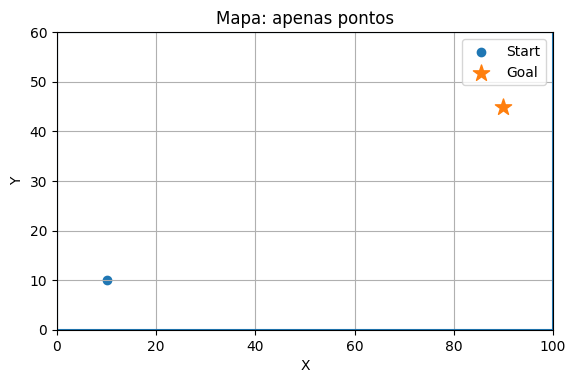

In [147]:
total_clearance = RADIUS + MARGIN_FROM_POINTS
plot_map_and_points(
    BOUNDS, START, GOAL,
    "Mapa: apenas pontos"
)
plt.show()


In [148]:
if USE_RANDOM:
    centers = generate_random_centers(
        NUM_OBS, RADIUS, BOUNDS, START, GOAL,
        total_clearance,
        min_gap_between_obs=MIN_GAP_BETWEEN_OBS,
        border_gap=BORDER_GAP,
        max_tries=MAX_TRIES
    )
else:
    if len(MANUAL_CENTERS) != NUM_OBS:
        raise ValueError("NUM_OBS deve ser igual ao tamanho de MANUAL_CENTERS.")
    centers = validate_manual_centers(
        MANUAL_CENTERS, RADIUS, BOUNDS, START, GOAL,
        total_clearance,
        min_gap_between_obs=MIN_GAP_BETWEEN_OBS,
        border_gap=BORDER_GAP
    )

print(f"{len(centers)} centros gerados.")
centers[:8]  # prévia


40 centros gerados.


[(62.827265458125304, 5.300559271578681),
 (29.30269728995897, 15.606958383738784),
 (71.75535170308915, 39.18837334599139),
 (86.08052022884578, 8.52081929672964),
 (42.81680741104488, 5.549455410779657),
 (24.11469368193151, 30.278474981374845),
 (63.789368275716136, 32.336956991367266),
 (92.06360264302387, 21.50291634585659)]

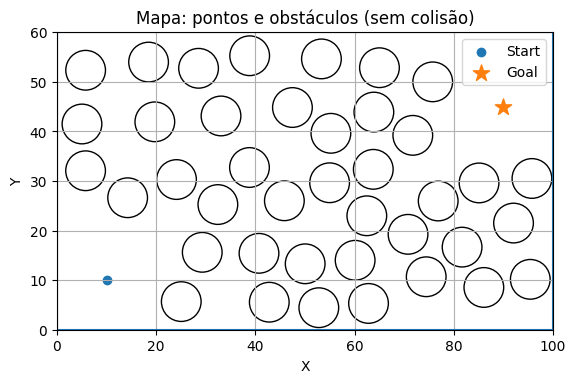

In [149]:
plot_map_and_points(
    BOUNDS, START, GOAL,
    "Mapa: pontos e obstáculos (sem colisão)"
)
plot_obstacles(centers, RADIUS)
plt.show()
